# Generative Adversarial Networks

### Begin work on making adversarial networks 
#### Create discriminator to discriminate between grapheme space 1 and grapheme space 2.
#### Create generator to create a mapping W on grapheme space 2 to make it indistinguishable from grapheme space 1.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import tqdm
from torch.utils.data import Dataset, DataLoader
import math
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from random import randint
from sklearn.utils import shuffle
import time
import copy

In [2]:
class Encoder(nn.Module):
    def __init__(self,grapheme_shape,embedding_units, vocab,hidden_units=50):
        super(Encoder,self).__init__()
        self.vocab = vocab
        self.grapheme_shape = grapheme_shape
        self.hidden_units = hidden_units
        self.embedding_units = embedding_units
        
        #self.weights_1 = nn.Parameter(torch.empty(size=(self.embedding_units, self.grapheme_shape), requires_grad=True))
        #nn.init.normal_(self.weights_1)
        #self.bias_1 = nn.Parameter(torch.zeros(self.embedding_units), requires_grad=True)

        self.layer_1 = nn.Linear(grapheme_shape, hidden_units)
        self.layer_2 = nn.Linear(hidden_units, embedding_units)
        
    def normalize(self,embedding):

        emb_mean = embedding.mean(axis=0)
        
        emb_std = embedding.std(axis=0)

        return (embedding-emb_mean)/emb_std
        
    
    def forward(self,inputs):
        #out = F.linear(inputs, self.weights_1, self.bias_1)
        #out = nn.ReLU().forward(out)

        #out = F.linear(inputs, self.weights_1, self.bias1)
        out = self.layer_1.forward(inputs)
        out = nn.ReLU().forward(out)
        #out = F.linear(out, self.weights_2,self.bias2)
        out = self.layer_2.forward(out)
        out = self.normalize(out)
        #out = nn.ReLU().forward(out)
        return out

In [3]:
class EncoderMapWrapper(nn.Module):
    def __init__(self,encoder,mapper):
        super(EncoderMapWrapper,self).__init__()
        self.encoder = encoder
        self.mapper = mapper

    def forward(self,inputs):
        out = self.encoder(inputs)
        out = self.mapper(out)
        return out

In [4]:
vocab = torch.load("EnglishBPEVocab.pt")
freqs = torch.load("EnglishBPEFreqs.pt")

In [5]:
sortedFreqs = torch.argsort(freqs[0]).tolist()
topK = (sortedFreqs[::-1][1:5])

In [6]:
v = len(vocab)
def graph2int(graph):
    return vocab.index(graph)
    
def int2graph(index):
    return vocab[index]

def int2vec(integer):
    vec=torch.zeros(len(vocab))
    vec[integer]=1
    return vec

def graph2vec(graph):
    return (int2vec(graph2int(graph)))

def vec2graph(vec):
    return (int2graph(np.argmax(vec)))

In [7]:
class Discriminator(nn.Module):
    def __init__(self,size):
        super(Discriminator,self).__init__()
        #self.layer1 = nn.Linear(size, 512)
        #self.layer2 = nn.Linear(512, 64)
        #self.layer3 = nn.Linear(64, 1)
        self.size = size
        self.layer1 = nn.Linear(size, size*2)
        self.layer2 = nn.Linear(size*2, size*2)
        self.layer3 = nn.Linear(size*2,1)
        self.sig = nn.Sigmoid()
     

    def forward(self,x):
        x = nn.BatchNorm1d(self.size)(x)
        x = self.layer1(x)
        x = self.sig(x)
        x = nn.BatchNorm1d(self.size*2)(x)
        x = self.layer2(x)
        x=self.sig(x)
        x=self.layer3(x)
        x = self.sig(x)
        return x
        #x = self.layer1.forward(x)
        #x = nn.ReLU().forward(x)
        #x = self.layer2.forward(x)
        #x = nn.ReLU().forward(x)
        #x = self.layer3.forward(x)
        #x = self.sig(x)
        #return x

In [8]:
class Generator(nn.Module):
    def __init__(self, source_dim, target_dim):
        super(Generator,self).__init__()
        self.W = nn.Linear(source_dim, target_dim,bias=False)        

    def forward(self,x):
        
        output = self.W(x)
        return output

In [9]:
embed_units1 = 40
embed_units2 = 40
state_dictSeed1=torch.load('experiments/EnglishBPE50Epochs/model/EnglishBPE40embeddings.pt')
state_dictSeed2=torch.load('experiments/EnglishBPE50Epochs/model/EnglishBPE40embeddings.pt')

encoder_src = Encoder(grapheme_shape=228,embedding_units=embed_units1,vocab=vocab)
encoder_src.load_state_dict(state_dictSeed1)
 
g_tgt = Generator(40,40)

#Orthogonolize data
g_tgt_map = g_tgt.W.weight.data
g_tgt_map.copy_((1.01) * g_tgt_map - 0.01 * g_tgt_map.mm(g_tgt_map.t().mm(g_tgt_map)))

encoder_tgt = Encoder(grapheme_shape=228,embedding_units=embed_units2,vocab=vocab)
encoder_tgt.load_state_dict(state_dictSeed2)
encoder_tgt = EncoderMapWrapper(encoder_tgt,g_tgt)

### Build Data

In [10]:
source_data = torch.empty(size=(v,40))
target_data = torch.empty(size=(v,40))


source_data = encoder_src.forward(torch.eye(v))
target_data = encoder_tgt.forward(torch.eye(v))


In [11]:
def genOneHot(labels,vocab_size):
    one_hot = torch.eye(vocab_size)
    return one_hot[labels]

In [12]:
def DiscriminatorLoss(real_pred, fake_pred):
    m = fake_pred.shape[0]
    n = real_pred.shape[0]
    #loss = - (1/m) * torch.log(fake_pred).sum() - (1/n) * torch.log(1-real_pred).sum() # paper/code
    loss = - (1/m) * torch.log(1-fake_pred).sum() - (1/n) * torch.log(real_pred).sum() # Tim original + Goodfellow 2014
    
    return loss
    
def GeneratorLoss(real_pred, fake_pred):
    m = fake_pred.shape[0]
    n = real_pred.shape[0]
    
    #loss = - (1/m) * torch.log(1 - fake_pred).sum() - (1/n) * torch.log(real_pred).sum() # paper/code
    loss = - (1/m) * torch.log(fake_pred).sum() - (1/n) * torch.log(1-real_pred).sum() # Tim
    #loss = - (1/m) * torch.log(fake_pred).sum() # Goodfellow 2014
    return loss

In [21]:
def get_avg_NN(g_current):
    normalReal = (target_data.detach().numpy())
    normalGen = (g_current(source_data).detach().numpy())

    l=0
    total_dist=0
    #For each real (pre mapped target), get the closest mapped source item
    for real in normalReal:
        dists = np.square(normalGen - real).sum(axis=1)
        nearest = (np.argsort(dists))
        realID = graph2int(vocab[l])
        dist_n = (np.where(nearest==realID)[0][0])
        total_dist+=dist_n
        l+=1
    return total_dist/228

def get_avg_dist(g_current):

    normalTgt = (target_data)
    normalGen = (g_current(source_data))
    distMap=((normalGen - normalTgt)**2).mean(axis=1).mean().item()
    #distOrig = ((originalSrc - normalTgt)**2).mean(axis=1).mean().item()
    return distMap
def meanSimilarity(embeddings1,neighbourhood_e1,embeddings2):
    r_sim = torch.empty(size=(embeddings1.shape[0],))
    k = neighbourhood_e1.shape[1]
    
    for i,emb in enumerate(embeddings1):
        n_list=(neighbourhood_e1[i].to(int).tolist())
        emb_neighbours = embeddings2[n_list]
        prods = (emb * emb_neighbours).sum(1)
        emb1Norm = torch.norm(emb) 
        emb2Norms=torch.norm(emb_neighbours,dim=1)
        norms = emb1Norm * emb2Norms
        r_sim[i]=(prods/(norms)).mean()
    return r_sim

def genNeighbourhood(emb1, emb2):
    k=20
    neighbourhoods = torch.empty(size=(emb1.shape[0],k))
    i=0
    for e1 in emb1:
        dists = torch.square(emb2 - e1).sum(axis=1)
        nearest = (torch.argsort(dists))
        top10 = (nearest[:k])
        neighbourhoods[i] = top10
        i+=1
    return neighbourhoods


    

In [14]:
def normalize(X_data):
    epsilon = 0.000001
    X_data = (X_data-X_data.mean(axis=0))/(X_data.std(axis=0)+epsilon)
    return X_data

## Training Loop Rewritten

In [15]:
src_batch_size = 64
tgt_batch_size = 64

src_vocab_size = v
tgt_vocab_size = v


loss_dict = {'discLoss':[],'genLoss':[],'avgDist':[],'CSLS':[]}

d = Discriminator(size=40)
#WGAN clipping
for params in d.parameters():
    params.data.clamp_(-0.03, 0.03)

g = Generator(40,40)

loss_d = nn.BCELoss()
loss_g = nn.BCELoss()

d_optimizer = optim.Adam(d.parameters(),lr=0.0001, weight_decay=0.95)# amsgrad=False, weight_decay=0,)
g_optimizer = optim.Adam(g.parameters(),lr=0.0001, weight_decay=0.95)# amsgrad=False, weight_decay=0,lr=0.001

#d_optimizer = optim.SGD(d.parameters(), lr=0.0001)
#g_optimizer = optim.SGD(g.parameters(), lr=0.0001)

val_tracker = 0


In [16]:
disc_iter = 3
gen_iter = 1

num_of_iterations = 100
num_of_epochs = 500

for epoch in range(num_of_epochs):
    disc_epoch_loss = 0
    gen_epoch_loss  = 0
    print("Epoch:",epoch)
    
    for iteration in range(num_of_iterations):
        disc_iter_loss=0
        gen_iter_loss=0
        
        #Run Discriminator 3 times
        for i in range(disc_iter):
            src_data = torch.Tensor(src_batch_size).random_(v).long()
            tgt_data = torch.Tensor(tgt_batch_size).random_(v).long()

            src_onehot = genOneHot(src_data,src_vocab_size)
            tgt_onehot = genOneHot(tgt_data,tgt_vocab_size)

            src_embeddings = (encoder_src(src_onehot))
            tgt_embeddings = (encoder_tgt(tgt_onehot))

            mapped_src_embeddings = (g(src_embeddings))

            disc_input = torch.cat([mapped_src_embeddings,tgt_embeddings],0)
            labels  = torch.Tensor(src_batch_size+tgt_batch_size).zero_().float()
            labels[: src_batch_size] = 0 
            labels[src_batch_size :] = 1 

            disc_pred = d(disc_input)
            #regular loss (BCE)
            #disc_loss = loss_d(disc_pred.squeeze(1),labels)
            #WGAN Loss
            disc_loss = disc_pred[:src_batch_size].mean() - disc_pred[src_batch_size:].mean()
            disc_loss.backward()
            d_optimizer.step()

            disc_epoch_loss += disc_loss.item()
            disc_iter_loss+=disc_loss.item()
        
        for i in range(gen_iter):
            #Generator Learning
            src_data = torch.Tensor(src_batch_size).random_(v).long()
            tgt_data = torch.Tensor(tgt_batch_size).random_(v).long()

            src_onehot = genOneHot(src_data,src_vocab_size)
            tgt_onehot = genOneHot(tgt_data,tgt_vocab_size)

            src_embeddings = (encoder_src(src_onehot))         
            mapped_src_embeddings = g(src_embeddings)

            disc_input = mapped_src_embeddings
            labels  = torch.Tensor(src_batch_size).zero_().float()
            labels[: src_batch_size] = 1 

            disc_pred = d(disc_input)
            #Regular loss (BCE)
            #gen_loss = loss_g(disc_pred.squeeze(1),labels)
            #WGAN loss
            gen_loss=-disc_pred.mean()
            gen_iter_loss += gen_loss.item()
            gen_epoch_loss += gen_loss.item()
            gen_loss.backward()
            g_optimizer.step()
            g_map = g.W.weight.data
            g_map.copy_((1.1) * g_map - 0.1 * g_map.mm(g_map.t().mm(g_map)))

            
        loss_dict['genLoss'].append(gen_iter_loss/gen_iter)
        loss_dict['discLoss'].append(disc_iter_loss/disc_iter)
        loss_dict['avgDist'].append(get_avg_dist(g))

    #CSLS Validation
    normMapped = (g(source_data))
    normTarget= (target_data)

    topKMappings = normMapped[topK]

    topKNeighboursSrc = genNeighbourhood(topKMappings,normTarget)
    topKNeighboursTgt = genNeighbourhood(normTarget,normMapped)
    
    r_mappings = meanSimilarity(topKMappings, topKNeighboursSrc, normTarget)
    r_targets = meanSimilarity(normTarget, topKNeighboursTgt, normMapped)
    
    dotProduct = topKMappings@normTarget.t()
    topKNorm = torch.norm(topKMappings,dim=1)
    normTargetNorm = torch.norm(normTarget,dim=1)
    normProd = torch.outer(topKNorm,normTargetNorm)
    cosSim = torch.div(dotProduct,normProd)
    NN = cosSim.argmax(dim=1)

    NNEmbeddings = normTarget[NN]

    dotProduct = torch.diag(topKMappings@NNEmbeddings.t())
    NNEmbeddingsNorm = torch.norm(NNEmbeddings,dim=1)

    cosSim = dotProduct/(NNEmbeddingsNorm * topKNorm)
    meanCosSim = cosSim.mean()

    loss_dict['CSLS'].append(meanCosSim.item())
    print(meanCosSim.item())
    
    if meanCosSim.item() > val_tracker:
        bestModel = copy.deepcopy(g)
        #g_optimizer.param_groups[0]['lr'] = 0.7*g_optimizer.param_groups[0]['lr']
        #d_optimizer.param_groups[0]['lr'] = 0.7*d_optimizer.param_groups[0]['lr']
        val_tracker = meanCosSim.item()
        #print("Decreasing LR.")
    
        
    print("Generator Loss:",gen_epoch_loss/(num_of_iterations*gen_iter))
    print("Discriminator Loss:",disc_epoch_loss/(num_of_iterations*disc_iter))
    print("\n")
    

Epoch: 0
0.24379636347293854
Generator Loss: -0.6858349746465683
Discriminator Loss: -0.0019350998600323995


Epoch: 1
0.2394089251756668
Generator Loss: -0.8378936660289764
Discriminator Loss: -0.11883420705795288


Epoch: 2
0.2290528565645218
Generator Loss: -0.8015426826477051
Discriminator Loss: -0.2163104909658432


Epoch: 3
0.22025687992572784
Generator Loss: -0.7860238999128342
Discriminator Loss: -0.23971219221750895


Epoch: 4
0.20765970647335052
Generator Loss: -0.7714040523767471
Discriminator Loss: -0.25584448675314586


Epoch: 5
0.20341216027736664
Generator Loss: -0.7618485301733017
Discriminator Loss: -0.2653864099582036


Epoch: 6
0.18385900557041168
Generator Loss: -0.7516971635818481
Discriminator Loss: -0.27716234445571897


Epoch: 7
0.18110525608062744
Generator Loss: -0.7388139575719833
Discriminator Loss: -0.2849910483757655


Epoch: 8
0.18415744602680206
Generator Loss: -0.7311281180381775
Discriminator Loss: -0.2956917844216029


Epoch: 9
0.18775439262390137
Gen

0.2324598729610443
Generator Loss: -0.9955061995983123
Discriminator Loss: -0.8853031011422475


Epoch: 77
0.22904539108276367
Generator Loss: -0.992115815281868
Discriminator Loss: -0.8904787216583888


Epoch: 78
0.22503221035003662
Generator Loss: -0.9948284882307052
Discriminator Loss: -0.8906582208474477


Epoch: 79
0.22132590413093567
Generator Loss: -0.994411770105362
Discriminator Loss: -0.8946628461281458


Epoch: 80
0.21823850274085999
Generator Loss: -0.9981996840238572
Discriminator Loss: -0.9015749776363373


Epoch: 81
0.21534250676631927
Generator Loss: -0.9957307904958725
Discriminator Loss: -0.9043395489454269


Epoch: 82
0.21246442198753357
Generator Loss: -0.9942744815349579
Discriminator Loss: -0.9063302858670552


Epoch: 83
0.2100163996219635
Generator Loss: -0.9963798236846924
Discriminator Loss: -0.907983399828275


Epoch: 84
0.20817945897579193
Generator Loss: -0.9951173728704452
Discriminator Loss: -0.9123770346244177


Epoch: 85
0.2063359022140503
Generator Loss

0.18645450472831726
Generator Loss: -0.9999132937192917
Discriminator Loss: -0.9858824108044306


Epoch: 153
0.187621608376503
Generator Loss: -0.9999280333518982
Discriminator Loss: -0.985308465162913


Epoch: 154
0.18909242749214172
Generator Loss: -0.999766097664833
Discriminator Loss: -0.9872240807612737


Epoch: 155
0.1900588572025299
Generator Loss: -0.9999400055408478
Discriminator Loss: -0.987285261352857


Epoch: 156
0.1906500905752182
Generator Loss: -0.9997949463129043
Discriminator Loss: -0.9858086627721786


Epoch: 157
0.19082826375961304
Generator Loss: -0.9998516070842743
Discriminator Loss: -0.9877842605113983


Epoch: 158
0.1906544417142868
Generator Loss: -0.9995571756362915
Discriminator Loss: -0.9872821640968322


Epoch: 159
0.19004157185554504
Generator Loss: -0.9997573018074035
Discriminator Loss: -0.9882759835322698


Epoch: 160
0.1897522658109665
Generator Loss: -0.9997061979770661
Discriminator Loss: -0.9880216403802236


Epoch: 161
0.19015610218048096
Generato

0.19259047508239746
Generator Loss: -0.9998399764299393
Discriminator Loss: -0.9961567314465841


Epoch: 229
0.19385217130184174
Generator Loss: -0.9999141454696655
Discriminator Loss: -0.996491072177887


Epoch: 230
0.19508925080299377
Generator Loss: -0.9998052829504013
Discriminator Loss: -0.996557510693868


Epoch: 231
0.19640132784843445
Generator Loss: -0.9999947333335877
Discriminator Loss: -0.9969481192032497


Epoch: 232
0.1974768340587616
Generator Loss: -0.9996428447961807
Discriminator Loss: -0.9965298350652059


Epoch: 233
0.19850026071071625
Generator Loss: -0.9995464992523193
Discriminator Loss: -0.9969237999121348


Epoch: 234
0.19938118755817413
Generator Loss: -0.9999928897619248
Discriminator Loss: -0.9962737131118774


Epoch: 235
0.20023301243782043
Generator Loss: -0.999992014169693
Discriminator Loss: -0.9968087073167166


Epoch: 236
0.20140030980110168
Generator Loss: -0.999993891119957
Discriminator Loss: -0.9965909798940022


Epoch: 237
0.2022288590669632
Gener

0.20449694991111755
Generator Loss: -0.9999910765886306
Discriminator Loss: -0.9983851506312689


Epoch: 305
0.20438680052757263
Generator Loss: -0.9998236244916916
Discriminator Loss: -0.9971230999628703


Epoch: 306
0.20487245917320251
Generator Loss: -0.9995815891027451
Discriminator Loss: -0.9985034306844075


Epoch: 307
0.20603494346141815
Generator Loss: -0.9999418860673904
Discriminator Loss: -0.9979921841621399


Epoch: 308
0.20761191844940186
Generator Loss: -0.9996991848945618
Discriminator Loss: -0.9983935588598252


Epoch: 309
0.20825234055519104
Generator Loss: -0.9996873253583908
Discriminator Loss: -0.998132720987002


Epoch: 310
0.20854458212852478
Generator Loss: -0.9998170405626297
Discriminator Loss: -0.9978079932928086


Epoch: 311
0.2089890092611313
Generator Loss: -0.9991810029745102
Discriminator Loss: -0.9981903197367986


Epoch: 312
0.20898792147636414
Generator Loss: -0.9997897583246231
Discriminator Loss: -0.9987145849068959


Epoch: 313


KeyboardInterrupt: 

### Plot Loss

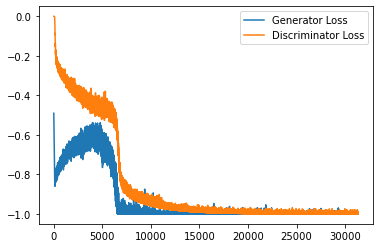

In [17]:
fig, ax = plt.subplots()
ax.plot((loss_dict['genLoss']),label='Generator Loss')
ax.plot((loss_dict['discLoss']),label='Discriminator Loss')
ax.legend(loc="upper right")

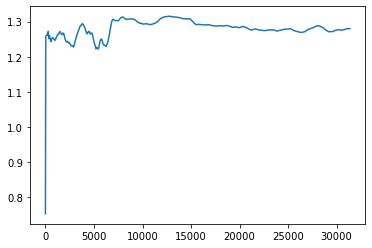

In [18]:
plt.plot((loss_dict['avgDist']))

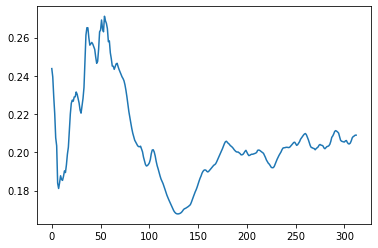

In [19]:
plt.plot((loss_dict['CSLS']))

In [34]:
normMapped = normalize(bestModel(source_data))
normTarget= normalize(target_data)

topKMappings = normMapped

topKNeighboursSrc = genNeighbourhood(topKMappings,normTarget)
topKNeighboursTgt = genNeighbourhood(normTarget,normMapped)
r_mappings = meanSimilarity(topKMappings, topKNeighboursSrc, normTarget)
r_targets = meanSimilarity(normTarget, topKNeighboursTgt, normMapped)

dotProduct = topKMappings@normTarget.t()
topKNorm = torch.norm(topKMappings,dim=1)
normTargetNorm = torch.norm(normTarget,dim=1)
normProd = torch.outer(topKNorm,normTargetNorm)
cosSim = torch.div(dotProduct,normProd)

NN = cosSim.argmax(dim=1)

totalDist=0

for i in range(topKMappings.shape[0]):
    iNearest=cosSim[i].argsort().numpy()[::-1]
    dist=np.where(iNearest==i)[0][0]
    totalDist+=dist
    print(int2graph(i),int2graph(NN[i].item()),dist)
print(totalDist/228)

a her 15
b s 62
c c 0
d s 16
e ver 53
f s 10
g s 16
h it 49
i her 71
j ver 114
k y 139
l s 94
m $ 141
n s 81
o ver 10
p un 225
q s 53
r s 102
s ir 175
t col 71
u i 87
v s 34
w y 153
x ac 133
y ie 127
z m 203
$ c 222
£ ver 93
in c 217
re ver 160
er ver 137
te z 183
an gu 11
ar ac 153
ti sh 130
en ver 105
on ac 127
co ver 30
st s 24
le col 134
or ce 160
ra it 142
li her 27
ri ac 97
ro ce 39
de ver 53
ch s 67
al on 135
at ci 193
ou sh 79
se c 123
si $ 186
la it 80
un on 144
di ce 61
sh al 185
ur ce 113
lo ver 20
pe c 153
ve do 159
th an 2
me her 7
ca ver 91
il s 138
ce stin 134
tio it 113
tion s 55
ta an 26
ma ce 160
ck it 67
be i 119
ge du 224
ne c 142
po ver 99
vi sh 89
con c 187
is c 136
as c 179
su ver 28
gh be 137
ci sh 100
ad ver 166
to ver 140
we s 116
mp s 5
ru c 177
ol ver 145
fi sh 164
he pla 21
sp un 98
ex ver 122
ke ver 184
che ce 93
bl s 79
men sp 223
ac tion 100
mi her 54
sa sh 120
tin col 135
mo ac 145
ter ver 169
pro ar 181
qu mp 80
cu c 197
bo ac 118
fe it 82
ir her 66
bu

## Projection Code

In [32]:
def projection(embeddings,axis,e_size,title,colour="black"):
    low_d_embed = (embeddings.detach().numpy() @ axis.T)

    x=normalize(low_d_embed[:,0])
    y=normalize(low_d_embed[:,1])
        
    fig, ax = plt.subplots(dpi=256)
    ax.scatter(x, y,color='white')
    fig.set_size_inches(25, 15.5)


    for i, txt in enumerate(vocab):
        ax.annotate(txt, (x[i], y[i]),size=10,color=colour)
    plt.title(title,size=20)
    return ax

def get_axis(embeddings,e_size):
    embeddings = embeddings.detach().numpy()
    #print(embeddings.shape)
    embedding_means = embeddings.mean(axis=0)
    embedding_std = embeddings.std(axis=0)+0.000000001
    #print(embedding_std)
    norm_embeddings = (embeddings-embedding_means)/embedding_std

    n,m = norm_embeddings.shape

    covariance_matrix = np.dot(norm_embeddings.T, norm_embeddings) / (n-1) #np.cov(norm_embeddings.T,bias=1)

    #print(type(covariance_matrix[0,37].equals(np.nan)))

    v,w = np.linalg.eig(covariance_matrix)

    idx = v.argsort()[::-1] # Sort descending and get sorted indices
    v = v[idx] # Use indices on eigv vector
    w = w[:,idx] # 

    variance_explained = []
    for i in v:
         variance_explained.append((i/sum(v))*100)
    red_Vecs = w[0:2,:]
    return red_Vecs

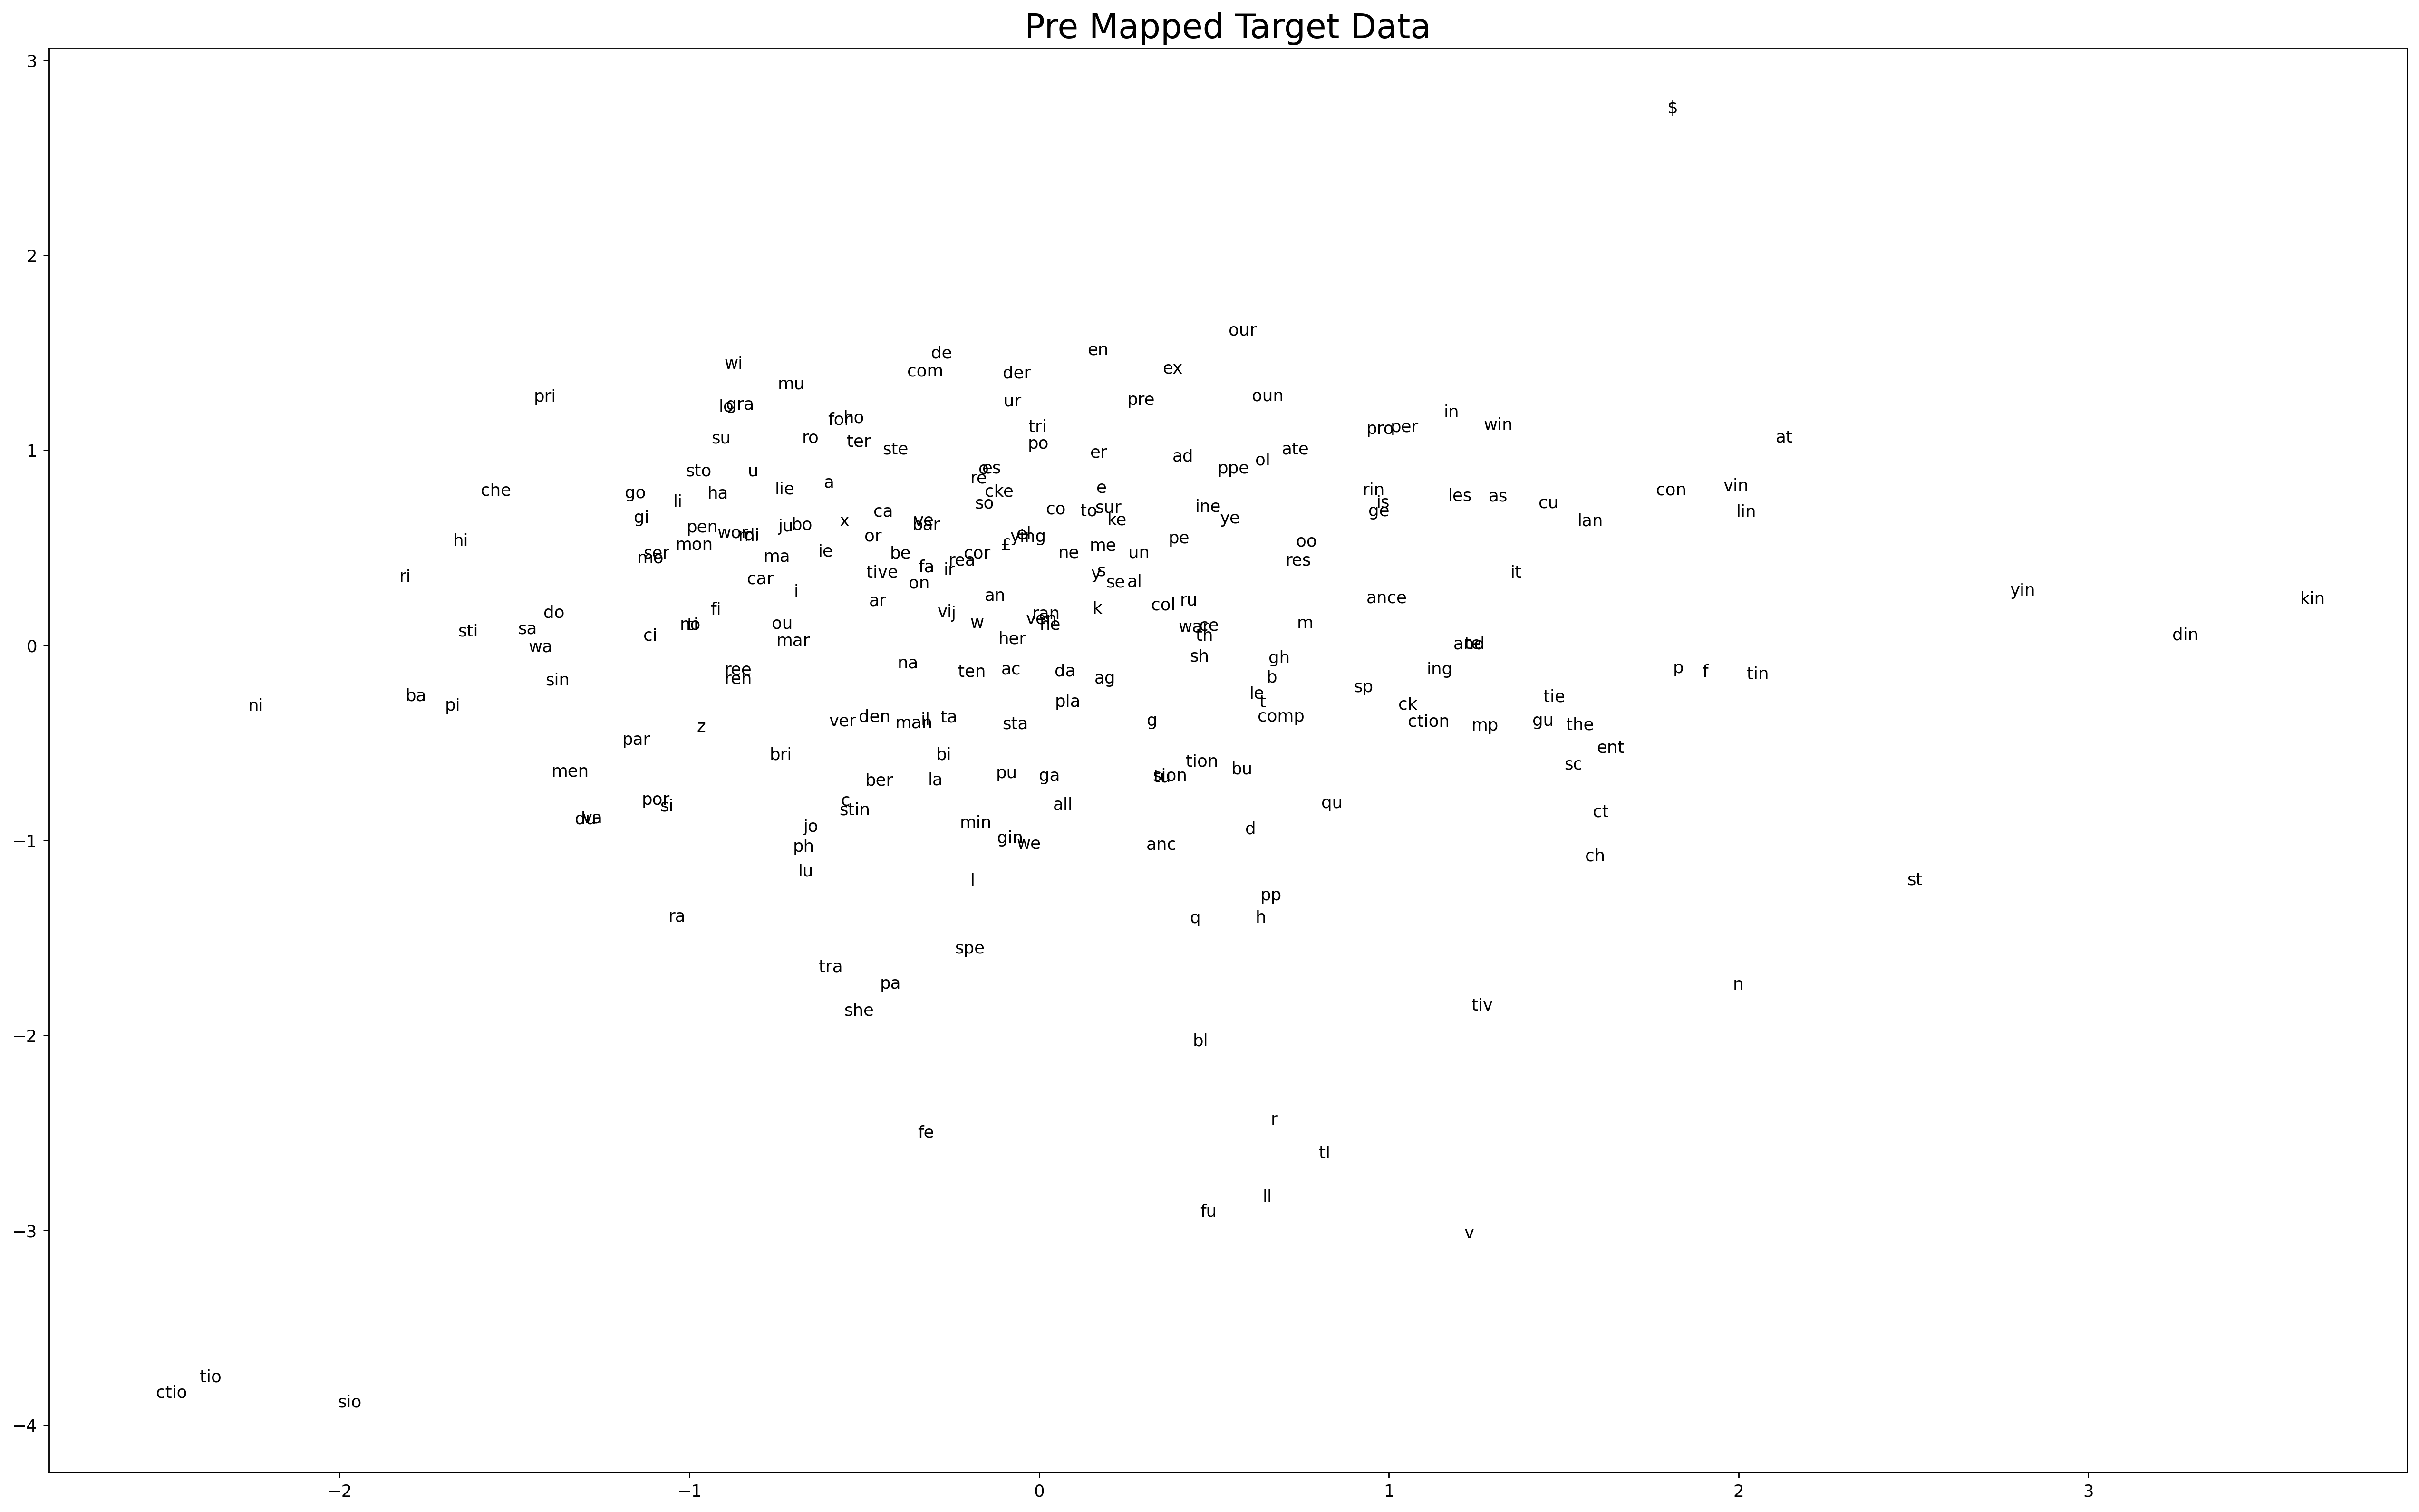

In [33]:
data = target_data
axis = get_axis(data,40)
ax1 = projection(data,axis,40,"Pre Mapped Target Data")

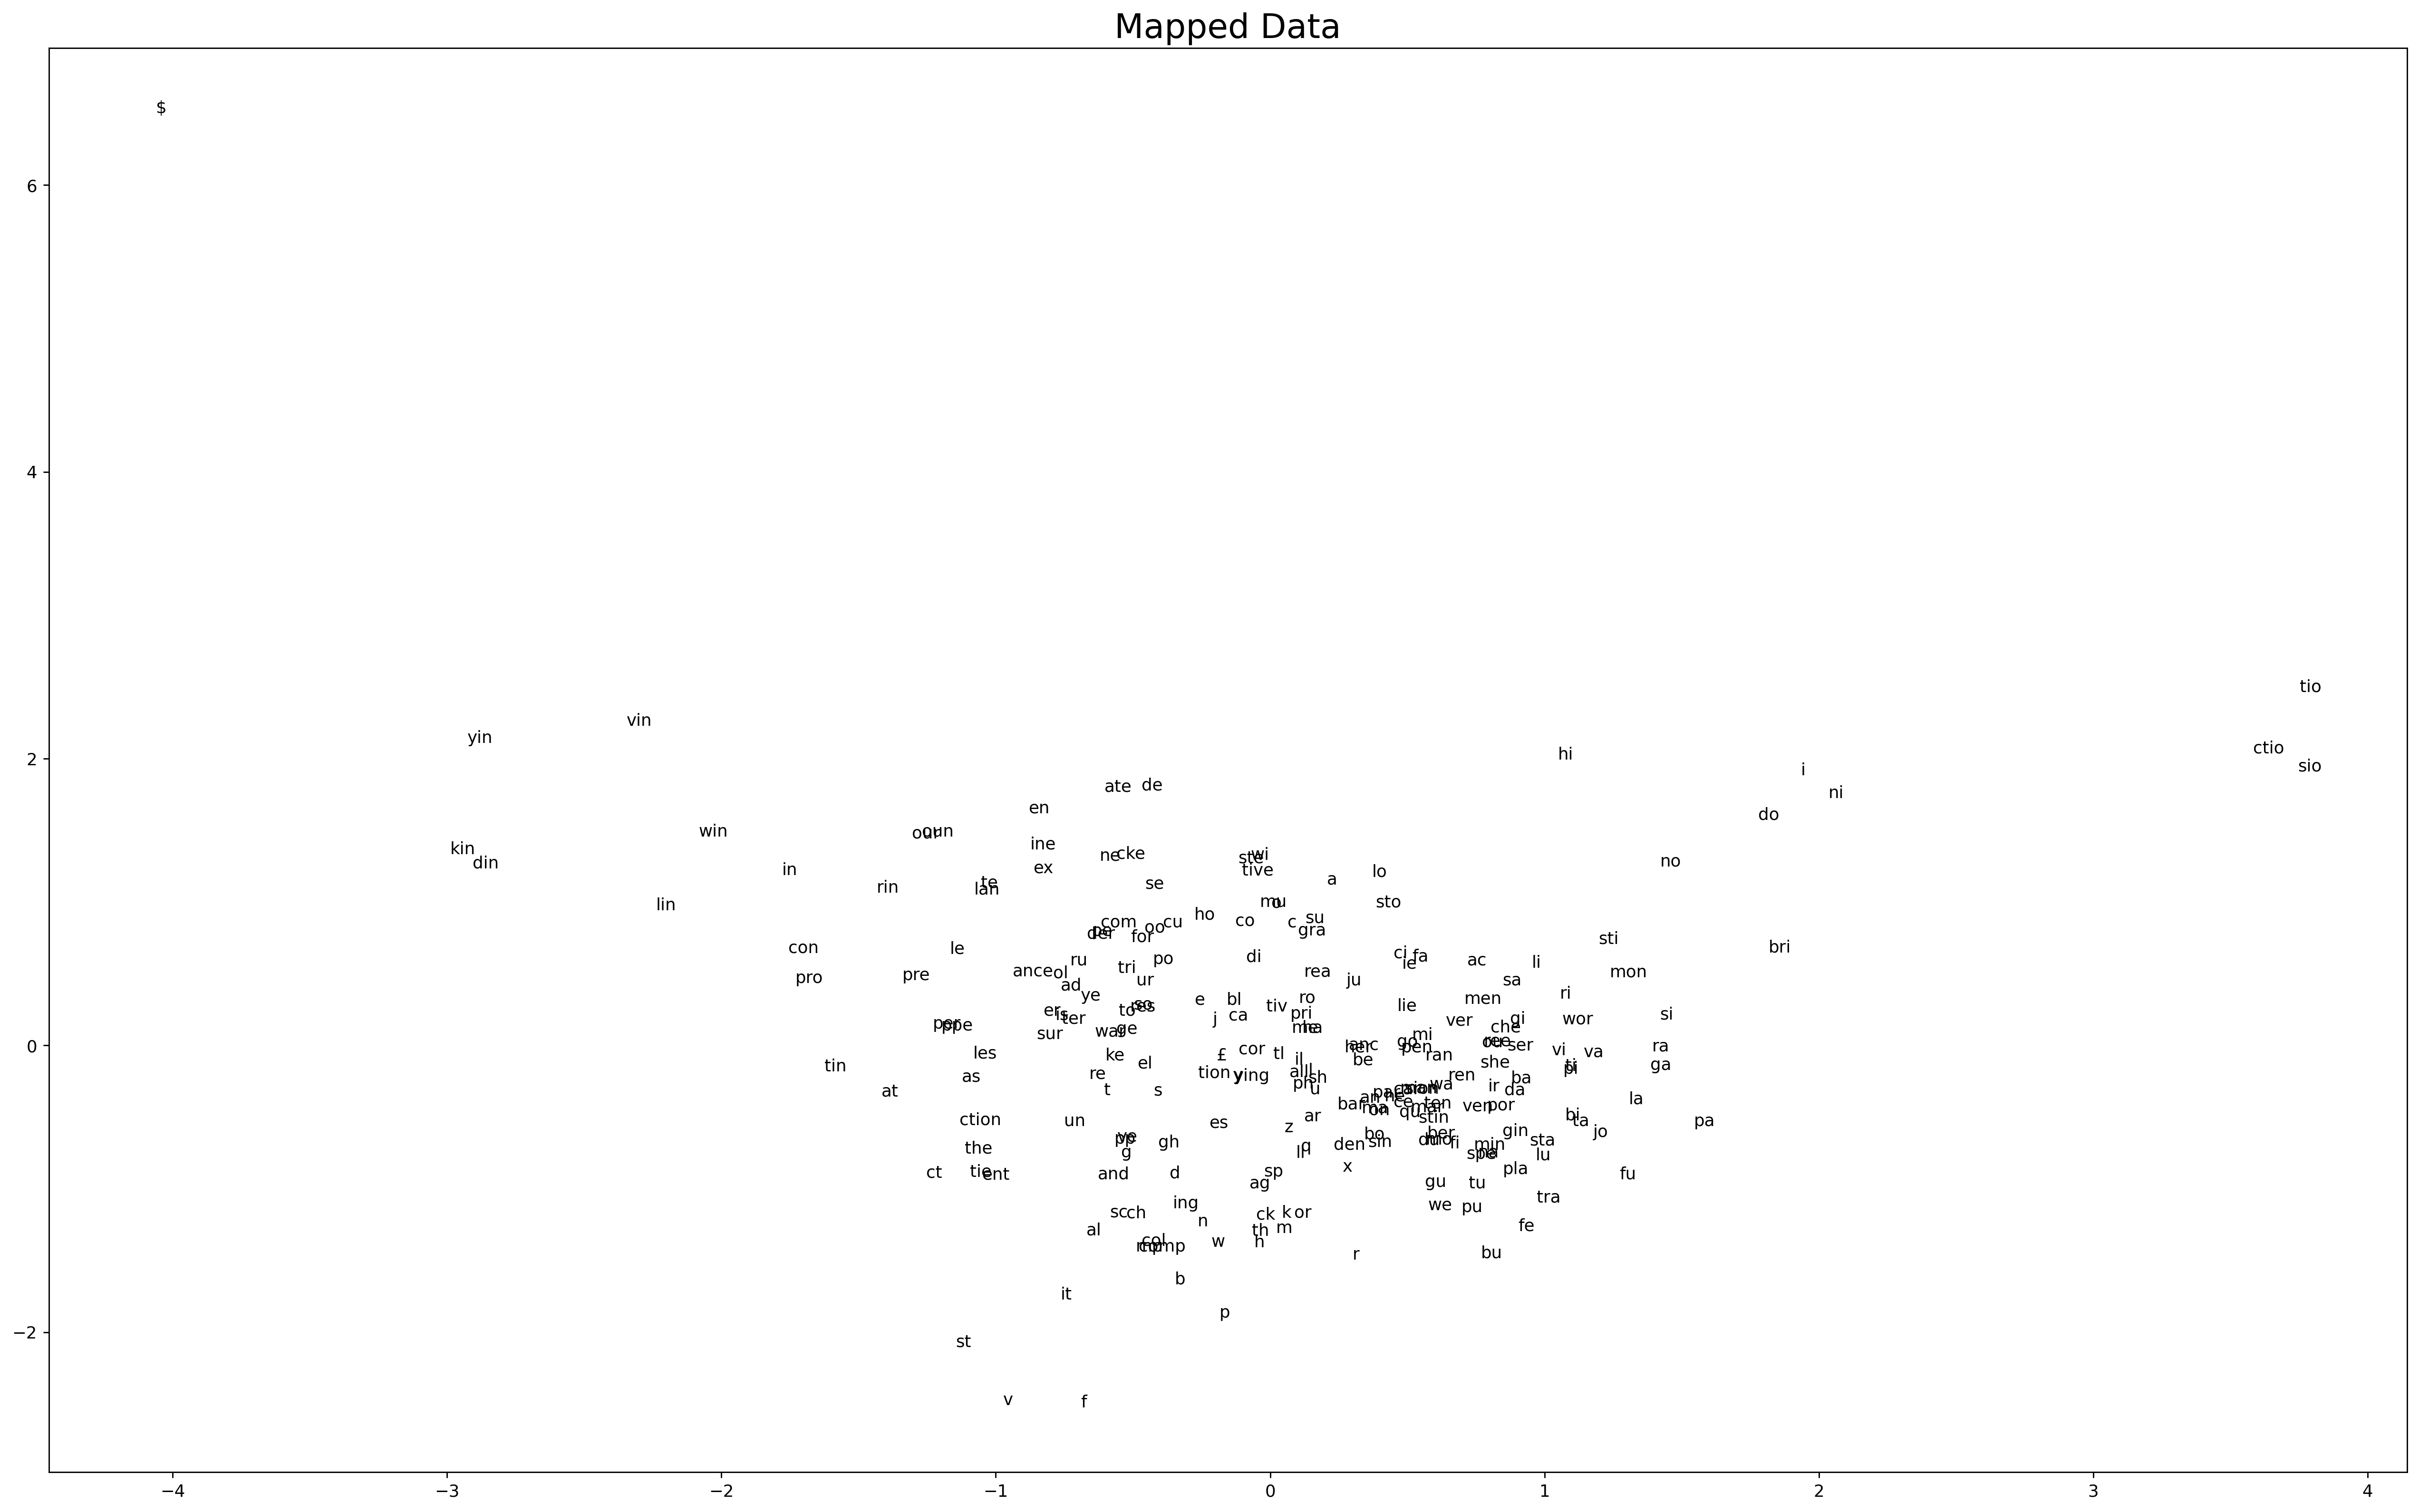

In [34]:
fake_data_map = bestModel(source_data)
ax2 = projection(fake_data_map,axis, 40, "Mapped Data")

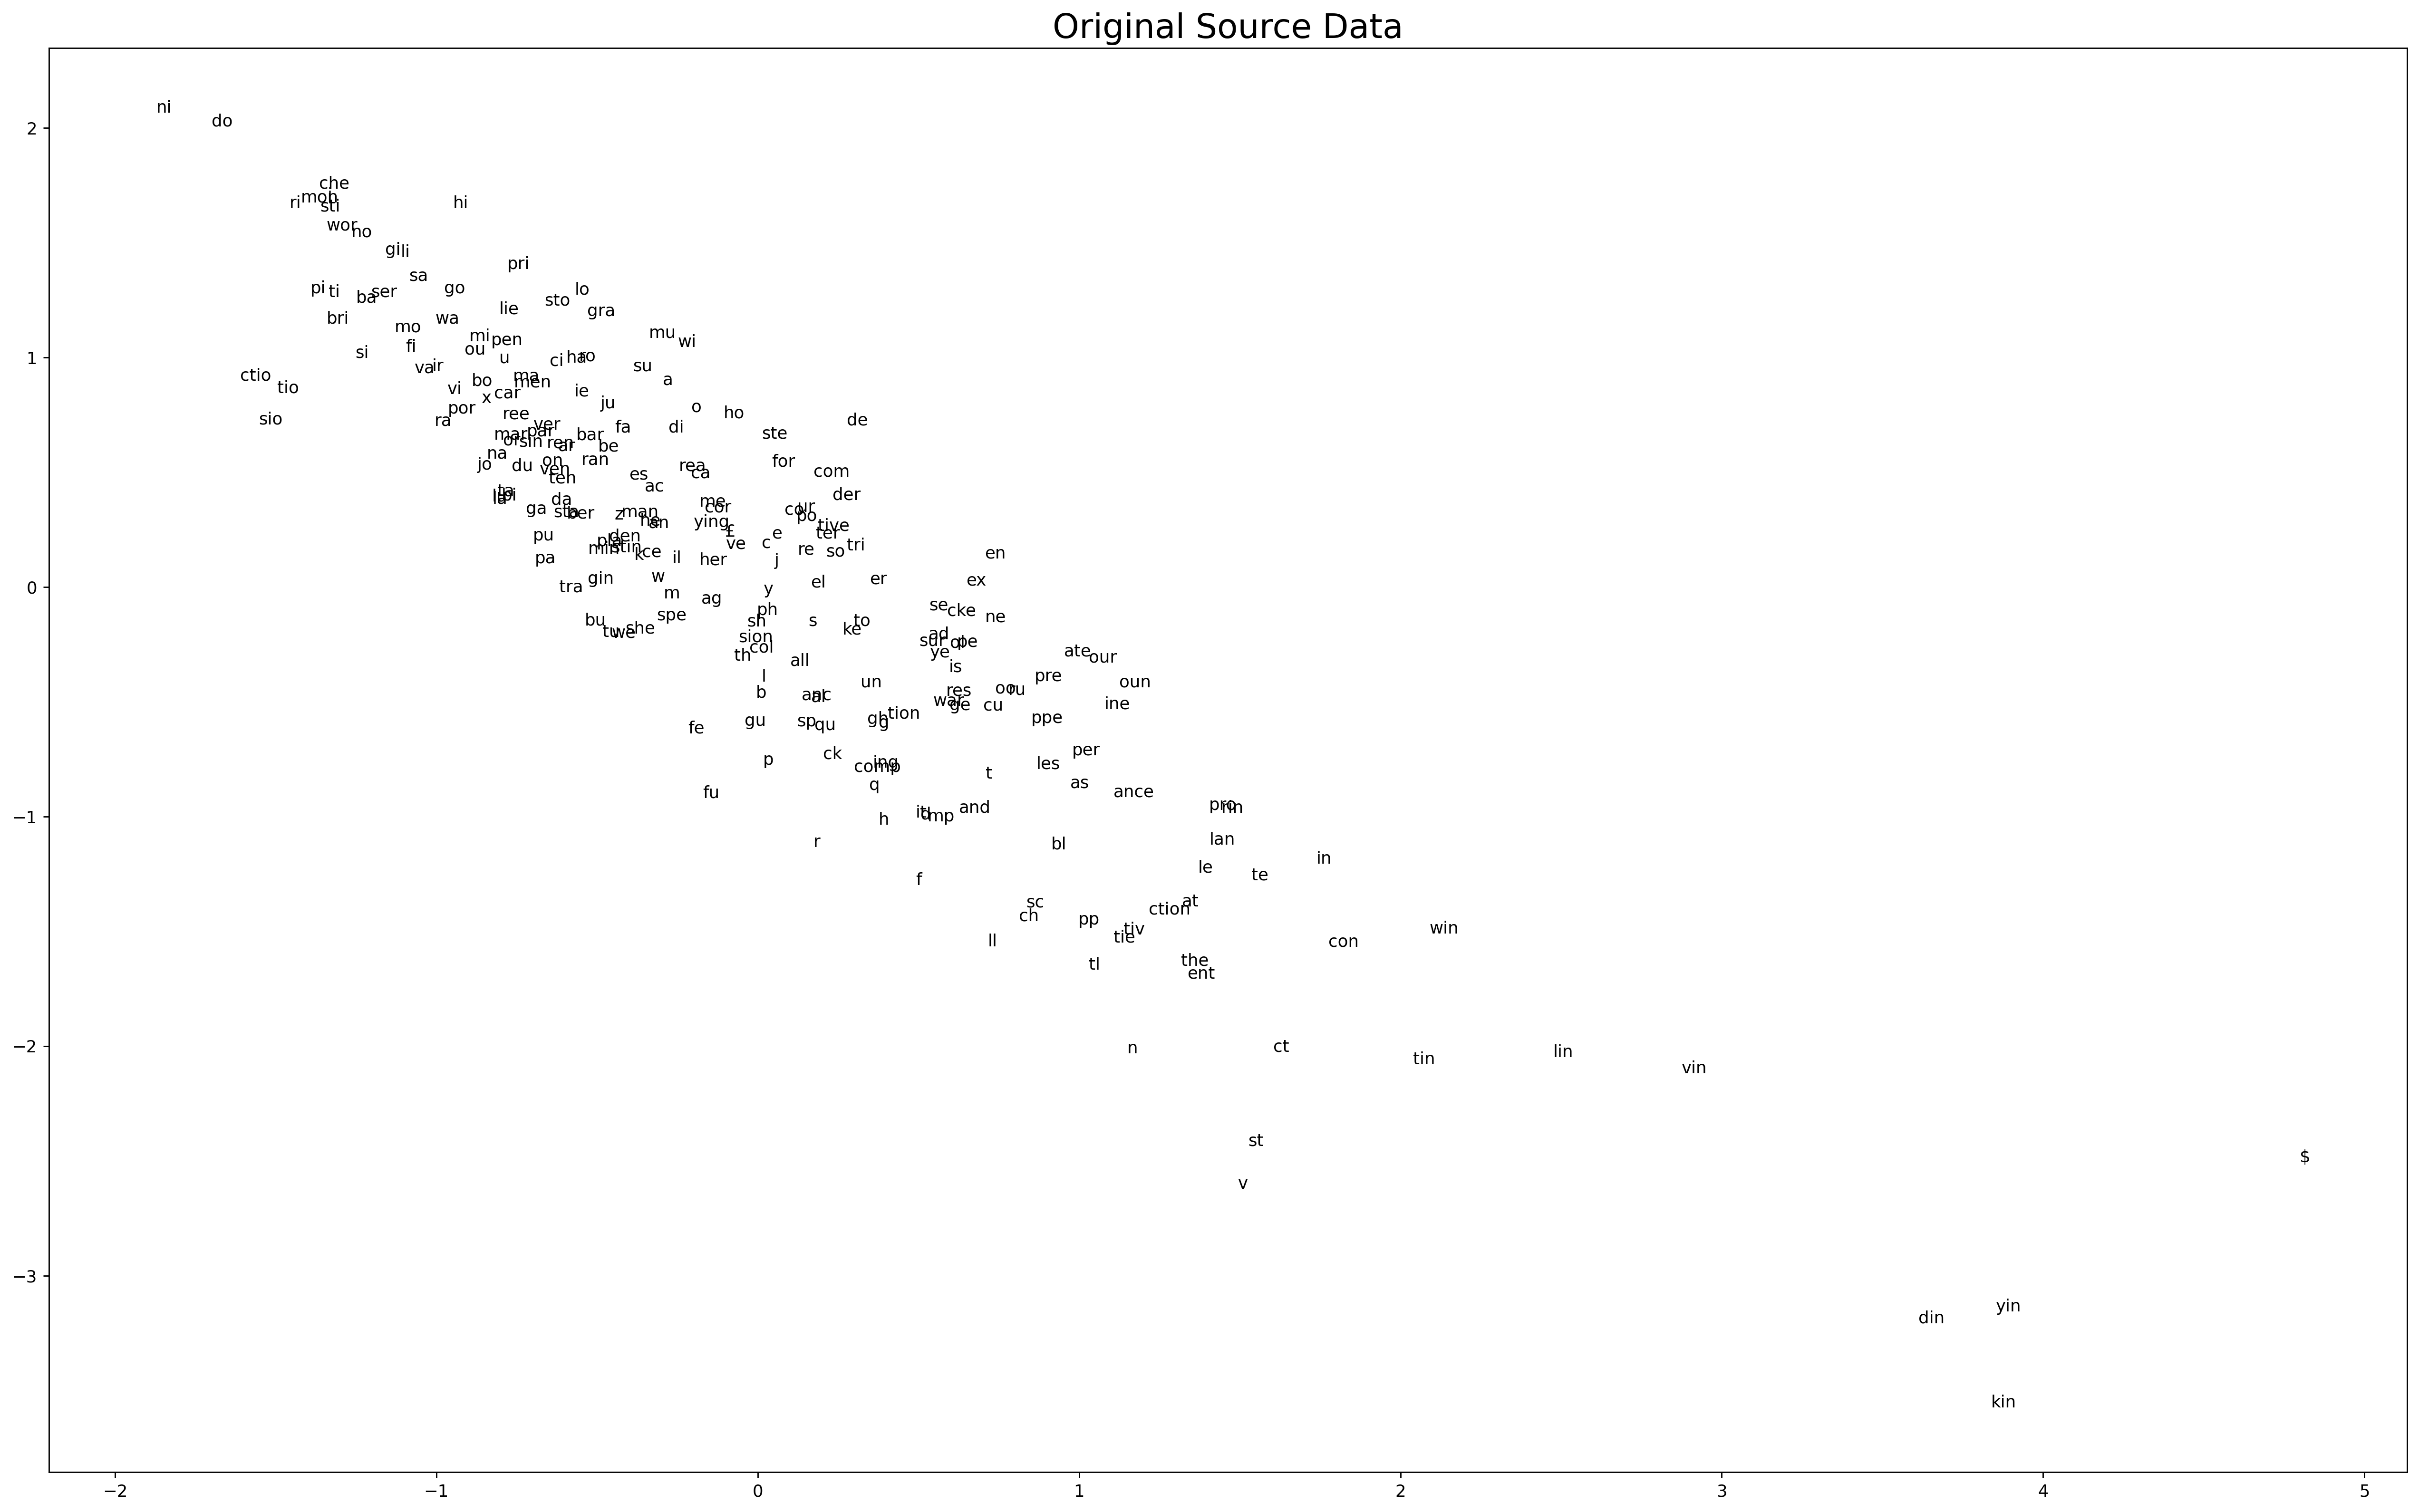

In [38]:
ax2 = projection(source_data,axis, 40, "Original Source Data")

## NN Metrics

In [81]:
#gen = g(fake_data).detach()

normalReal = normalize(target_data.detach().numpy())
normalGen = normalize(g(source_data).detach().numpy())

l=0
total_dist=0
#For each real (pre mapped target), get the closest mapped source item
for real in normalReal[0:1]:
    dists = np.square(normalGen - real).sum(axis=1)
    nearest = (np.argsort(dists))
    top10 = (nearest[:10])
    print(top10)
    realID = graph2int(vocab[l])
    print(np.where(nearest==realID))
    dist_n = (np.where(nearest==realID)[0][0])
    total_dist+=dist_n
    print(dist_n)
    print("Nearest neighbour of "+vocab[l]+" : "+vocab[nearest[0]]+", "+vocab[nearest[1]])
    l+=1
print(total_dist/228)
    

[  9  24 176  63  12  18 206 185 123 220]
(array([76]),)
76
Nearest neighbour of a : j, y
0.3333333333333333


In [65]:
#gen = g(fake_data).detach()

normalTgt = normalize(target_data)
normalGen = normalize(g(source_data))

originalTgt = normalize(target_data)
originalSrc = normalize(source_data)



distMap=((normalGen - normalTgt)**2).mean(axis=1).mean().item()
distOrig = ((originalSrc - normalTgt)**2).mean(axis=1).mean().item()
print(distMap)
print(distOrig)

2.1811766624450684
2.2070364952087402


In [143]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [205]:
normMapped = normalize(g(source_data))
normTarget= normalize(target_data)

tgt_neighbourhood=genNeighbourhood(normTarget,normMapped)
src_neighbourhood= genNeighbourhood(normMapped,normTarget)


n_list=(src_neighbourhood[0].to(int).tolist())
emb_neighbours = normTarget[n_list]

prods = (normMapped[0] * emb_neighbours).sum(1)
normMappedNorm = torch.norm(normMapped[0])       
tgt_norms=torch.norm(emb_neighbours,dim=1)
prods/(tgt_norms*normMappedNorm)

tensor([ 0.1000,  0.0881,  0.1367, -0.0190, -0.0827, -0.0083,  0.0204, -0.1057,
         0.0379, -0.0013], grad_fn=<DivBackward0>)

tensor([-1.0329, -3.2821,  1.1265, -1.7459, -0.0724, -0.1571, -0.5658,  0.3785,
        -0.4799, -0.4367, -0.2463, -3.2630,  0.3999,  1.7586,  2.6124, -2.1923,
         2.9153,  4.2155,  2.4057,  2.1849,  0.4642,  0.7606,  1.7440,  0.4134,
         1.7046, -0.4216, -2.2672, -0.2071,  0.5332, -0.7342, -0.6993,  0.7795,
         2.0621,  2.3468,  2.7809, -2.8671, -3.3689,  0.0332, -0.5126, -3.3110],
       grad_fn=<MeanBackward1>)

Parameter containing:
tensor([[-0.0775, -0.1452,  0.0142,  ...,  0.0661, -0.0518, -0.0189],
        [-0.1402, -0.0287, -0.0824,  ...,  0.1525, -0.0108, -0.0414],
        [-0.1317, -0.1573,  0.1557,  ...,  0.0608, -0.1540,  0.0478],
        ...,
        [ 0.1545, -0.0824, -0.0252,  ..., -0.0009, -0.0115, -0.0173],
        [ 0.0919,  0.1577, -0.0752,  ...,  0.1207, -0.0157,  0.0470],
        [ 0.0491, -0.1101,  0.0019,  ..., -0.1106,  0.1060,  0.0070]],
       requires_grad=True)

In [82]:
source_data.div_(source_data.norm(2, 1, keepdim=True).expand_as(source_data))

tensor([[-0.1119,  0.1470, -0.0549,  ...,  0.1270,  0.3315,  0.1160],
        [ 0.0657, -0.0462, -0.1474,  ...,  0.0279,  0.2667,  0.1012],
        [ 0.0434,  0.0287, -0.1566,  ..., -0.0481,  0.3353,  0.0490],
        ...,
        [-0.0258,  0.0838, -0.0833,  ...,  0.0983,  0.3154,  0.1316],
        [ 0.0741, -0.0379, -0.1331,  ...,  0.0092,  0.2549,  0.0909],
        [-0.0299,  0.0842, -0.0802,  ...,  0.0821,  0.3180,  0.1162]],
       grad_fn=<DivBackward0>)

In [80]:
source_data = (source_data-source_data.mean(axis=1))/source_data.std(axis=1)

tensor(0.0145, grad_fn=<MeanBackward0>)

In [154]:
source_data.std(axis=-2).shape

torch.Size([40])